In [13]:
from gs_quant.session import GsSession
# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',))  

### Volatility Skew & Smile Screen

This screen looks at historical implied volatility for 3m 25 delta options. The screen shows either the volatility smile or skew. The delta strike, option tenor and history can be adjusted. Relative refers to the vol adjusted results.

Volatility skew or risk reversal refers to 25d call vol - 25d put vol. Volatility smile or butterflys refer to (25d call vol + 25d put vol) / 2 - ATM vol.

In [14]:
from gs_quant.data import Dataset
import pandas as pd
pd.set_option('display.precision', 2)

def volatility_skew(bbids, start_date, end_date, tenor='3m', history='2y', strike_level='25D', smile=False, relative=False, plot=True):
    """
    Screens for Volatility Skew 
    defaults to risk reversal (25d call vol - 25d put vol)
    
    : param crosses: array of string FX pairs e.g. ['USDJPY', 'USDNOK']
    : param start_date: start date for volatility history
    : param end_date: end date for volatility history
    : param tenor: volatility tenor
    : param history: label for historical calculations  
    : param strike_level: defaults to 25D
    : param smile: if true, calculates butterfly else displays risk reversal
    : param relative: if true, skew is divided by ATM Vol
    """
    
    impvol_data = {}
    data = {}
    strikes = [f'{strike_level}C', f'{strike_level}P', 'DN']
    for cross in bbids:
        for strike in strikes:
            #replace with premium dataset for more history
            impvol_data[f'{cross}_{strike}'] = Dataset('FXIMPLIEDVOL').get_data(start_date, end_date, bbid=cross, tenor=tenor, deltaStrike=strike, location='NYC')['impliedVolatility']*100
        if smile:
            data[cross] = (impvol_data[f'{cross}_{strike_level}C'] + impvol_data[f'{cross}_{strike_level}P'])/2 - impvol_data[f'{cross}_DN']
        #risk reversal
        else:
            data[cross] = (impvol_data[f'{cross}_{strike_level}C'] - impvol_data[f'{cross}_{strike_level}P'])
        if relative:
            data[cross] = data[cross] /  impvol_data[f'{cross}_DN']
    df = pd.DataFrame(data)
    return get_screen(df, plot=plot, smile=smile, history=history)

In [24]:
from gs_quant.timeseries import last_value, change, percentiles
import matplotlib.pyplot as plt

def get_screen(data, strike_label='25D', history='2y', plot=True, smile=False):
    screen = {}
    for cross in data.columns:
        screen[cross] = {'Current': last_value(data[cross]),
                         '1w Change': last_value(change(data[cross].tail(5))),
                         f'{history} Min': min(data[cross]),
                         f'{history} Max': max(data[cross]),
                         '%-ile': last_value(percentiles(data[cross]))
                        }
    vol_screen = pd.DataFrame(screen).T
    
    if plot:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        vol_screen = vol_screen.sort_values('%-ile')
        label = 'Smile' if smile else 'Skew'
        top = vol_screen.iloc[-1]
        data[top.name].plot(ax=axes[0], title=f'Highest %-ile {label} ({top.name})')
        bottom = vol_screen.iloc[0]
        data[bottom.name].plot(ax=axes[1], title=f'Lowest %-ile {label} ({bottom.name})')
    return vol_screen

### Risk Reversal

Risk reversals refer to 25d call vol - 25d put vol. Relative risk reversals are computed as risk reversals divided by ATM vol.

3m 25D Risk Reversal


,Current,1w Change,2y Min,2y Max,%-ile
USDJPY,-0.99,0.06,-9.03,-0.78,99.21
GBPUSD,-0.64,0.29,-4.21,0.21,87.72
USDSEK,1.13,-0.05,-0.73,3.83,79.21
EURUSD,0.35,0.03,-3.37,2.49,78.42
USDCHF,-0.60,-0.09,-3.26,-0.23,76.53
USDNOK,1.52,0.13,-0.29,6.16,72.18
AUDUSD,-1.11,-0.03,-8.08,-0.44,40.20
NZDUSD,-1.00,-0.07,-8.12,-0.33,37.52
USDCAD,0.25,0.04,0.14,4.70,12.97


3m 25D Risk Reversal (Relative)


,Current,1w Change,2y Min,2y Max,%-ile
USDJPY,-0.16,0.01,-0.65,-0.14,99.31
GBPUSD,-0.08,0.03,-0.27,0.02,87.62
USDCHF,-0.09,-0.02,-0.32,-0.05,80.50
USDSEK,0.12,0.00,-0.06,0.24,77.92
USDNOK,0.12,0.01,-0.03,0.29,71.39
EURUSD,0.05,0.01,-0.27,0.26,70.79
AUDUSD,-0.11,-0.01,-0.47,-0.07,51.58
NZDUSD,-0.10,-0.01,-0.48,-0.04,44.26
USDCAD,0.04,0.01,0.02,0.39,3.66


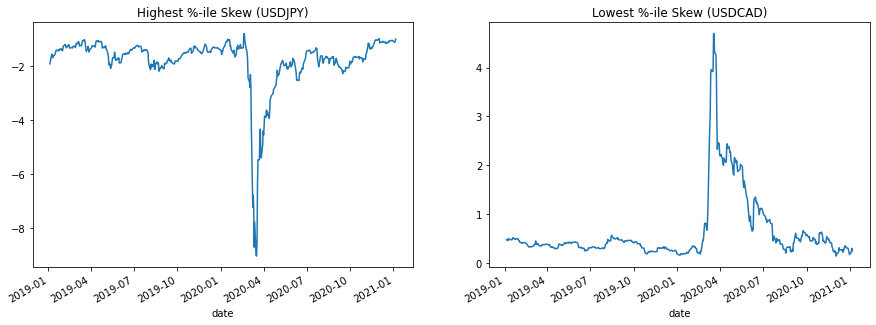

In [27]:
from datetime import date
from gs_quant.datetime import business_day_offset
from dateutil.relativedelta import relativedelta
end = business_day_offset(date.today(), -1, roll='forward')
start = business_day_offset(end - relativedelta(years=2), -1, roll='forward')


g10 = ['USDJPY', 'EURUSD', 'AUDUSD', 'GBPUSD', 'USDCAD', 'USDNOK', 'NZDUSD', 'USDSEK', 'USDCHF']
tenor='3m'
strike_level='25D'

risk_reversal = volatility_skew(g10, start_date=start, end_date=end, tenor=tenor, strike_level=strike_level)
relative_rr = volatility_skew(g10, start_date=start, end_date=end, tenor=tenor, strike_level=strike_level, relative=True, plot=False)
print(f'{tenor} {strike_level} Risk Reversal')
display(risk_reversal.sort_values('%-ile', ascending=False).style.background_gradient(subset=['%-ile']))

print(f'{tenor} {strike_level} Risk Reversal (Relative)')
display(relative_rr.sort_values('%-ile', ascending=False).style.background_gradient(subset=['%-ile']))

### Smile 

Butterflys refer to (25d call vol + 25d put vol) / 2 - ATM vol. Relative BF are computed as BF divided by ATM vol.

3m 25D Smile


,Current,1w Change,2y Min,2y Max,%-ile
USDNOK,0.44,-0.03,0.14,1.50,63.27
NZDUSD,0.35,0.01,0.19,1.57,65.94
AUDUSD,0.34,0.00,0.19,1.57,65.15
USDSEK,0.34,-0.01,0.13,1.11,80.69
GBPUSD,0.28,-0.01,0.16,1.36,23.17
USDJPY,0.27,0.00,0.21,1.33,38.61
USDCHF,0.24,0.00,0.15,1.25,68.22
USDCAD,0.23,-0.01,0.11,1.14,58.91
EURUSD,0.22,-0.03,0.12,1.42,62.08


3m 25D Smile (Relative)


,Current,1w Change,2y Min,2y Max,%-ile
USDJPY,0.04,0.00,0.03,0.11,41.88
USDCHF,0.04,0.00,0.02,0.11,64.85
NZDUSD,0.04,0.00,0.02,0.08,69.01
AUDUSD,0.04,0.00,0.02,0.08,66.83
USDNOK,0.04,-0.00,0.02,0.05,59.50
USDSEK,0.04,0.00,0.02,0.07,80.30
USDCAD,0.03,-0.00,0.02,0.10,58.32
EURUSD,0.03,-0.00,0.02,0.12,50.79
GBPUSD,0.03,0.00,0.02,0.08,39.90


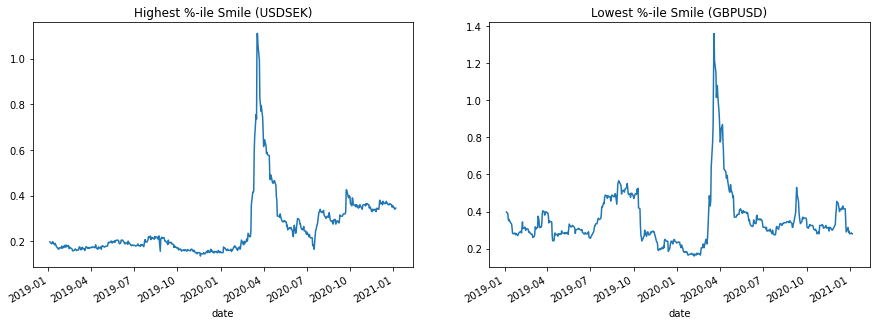

In [23]:
vol_smile = volatility_skew(g10, start_date=start, end_date=end, tenor=tenor,smile=True)
relative_smile = volatility_skew(g10, start_date=start, end_date=end, tenor=tenor, strike_level=strike_level, smile=True, relative=True, plot=False)
print(f'{tenor} {strike_level} Smile')
display(vol_smile.sort_values('Current', ascending=False).style.background_gradient(subset=['Current']))

print(f'{tenor} {strike_level} Smile (Relative)')
display(relative_smile.sort_values('Current', ascending=False).style.background_gradient(subset=['Current']))